## Homework

Dataset: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

Using January and February 2023 for "Yellow Taxi Trip Records"

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge 
from sklearn.metrics import root_mean_squared_error

In [9]:
# Load January 2023 data
january = pd.read_parquet('data/yellow_tripdata_2023-01.parquet')
# Load February 2023 data
february = pd.read_parquet('/home/z4hid/Desktop/githubProjects/mlops/Homeworks/01-intro/data/yellow_tripdata_2023-02.parquet')


### Q1. Downloading the data
Read the data for January. How many columns are there?

In [11]:
len(january.columns)

19

### Q2. Computing duration

What's the standard deviation of the trips duration in January?

In [12]:
# Now let's compute the duration variable. It should contain the duration of a ride in minutes.
january['duration'] = january.tpep_dropoff_datetime - january.tpep_pickup_datetime
january['duration'] = january['duration'].dt.total_seconds() / 60
# What's the standard deviation of the trips duration in January?
print(f"Standard deviation of the trips duration in January: {january['duration'].std()}")

Standard deviation of the trips duration in January: 42.59435124195458


## Q3. Dropping outliers
What fraction of the records left after you dropped the outliers?

In [ ]:
# Filter to keep only records with duration between 1 and 60 minutes (inclusive)
january_filtered = january[(january['duration'] >= 1) & (january['duration'] <= 60)]

print("Filtered dataset size:", len(january_filtered))

# Calculate the fraction of records remaining after filtering
fraction = len(january_filtered) / len(january)
percentage = fraction * 100

print(f"Fraction of records remaining: {fraction:.4f}")
print(f"Percentage of records remaining: {percentage:.2f}%")


Filtered dataset size: 3009173
Fraction of records remaining: 0.9812
Percentage of records remaining: 98.12%


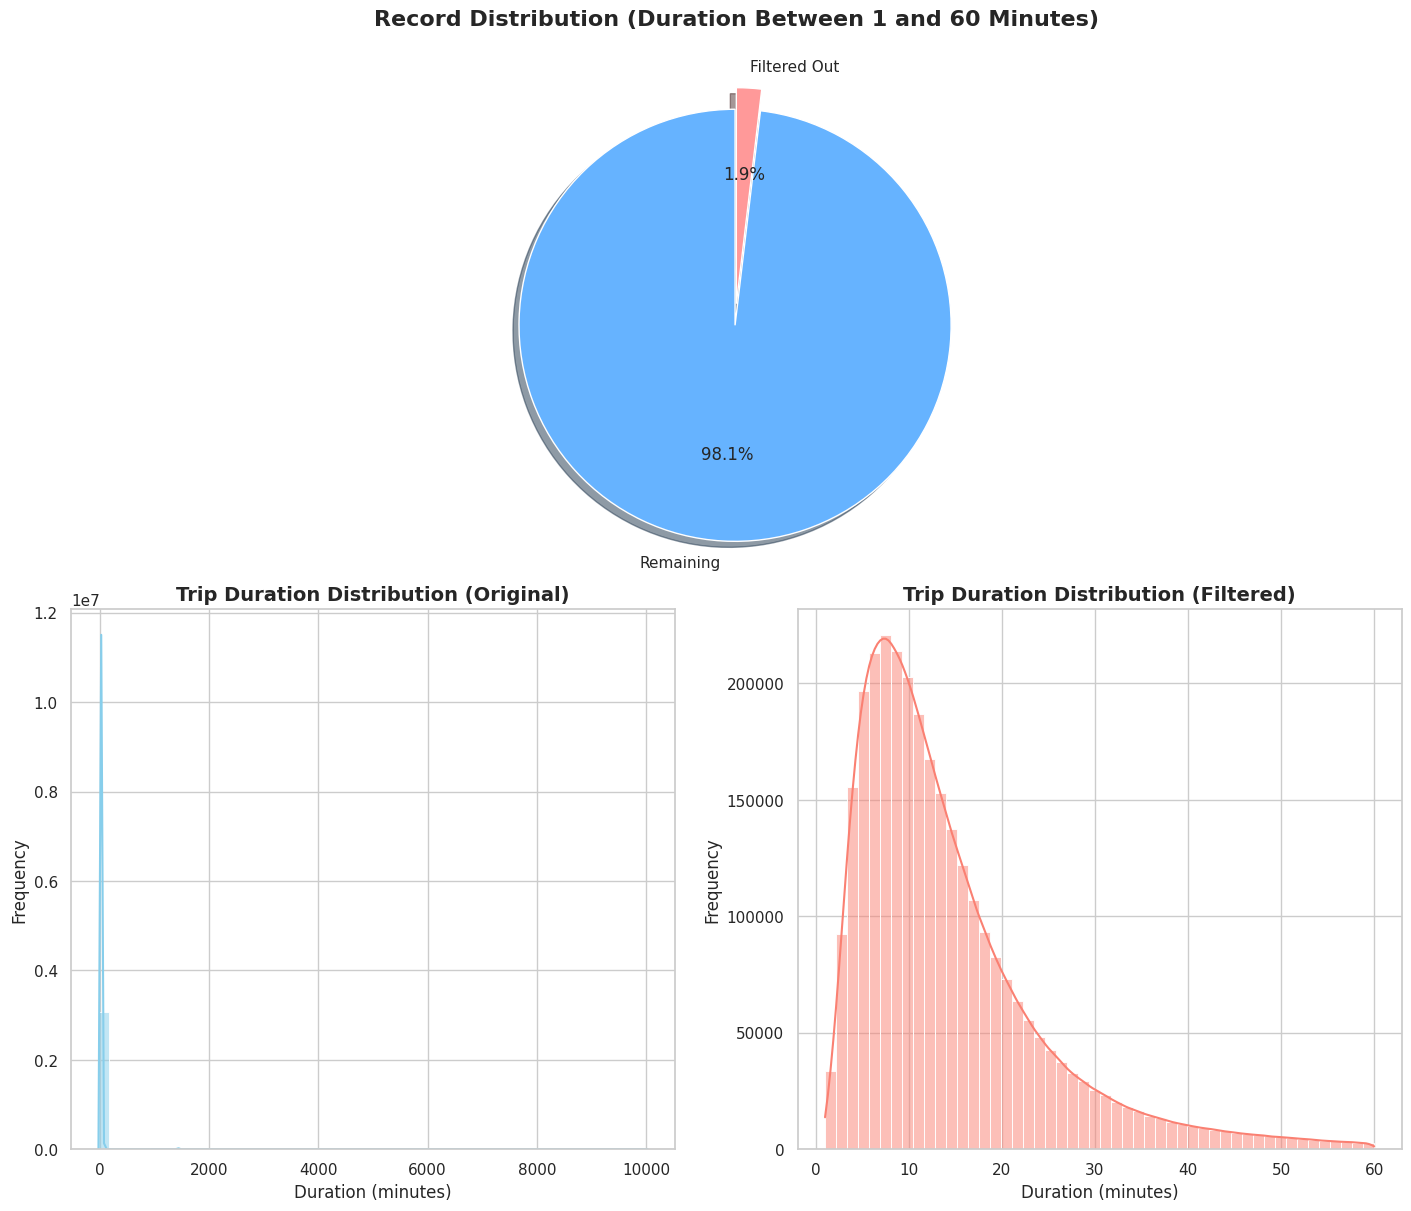

In [15]:
# For improved visual aesthetics, let's use seaborn's theme and a gridspec layout.
sns.set_theme(style="whitegrid")

# Create a figure with two rows:
# Row 1: A centered pie chart showing record distribution.
# Row 2: Two side-by-side histograms with kernel density estimates.
fig = plt.figure(constrained_layout=True, figsize=(14, 12))
gs = fig.add_gridspec(2, 2)

# Pie chart spanning the full width in the first row
ax_pie = fig.add_subplot(gs[0, :])
explode = (0.1, 0)  # slightly pull out the "Remaining" slice for emphasis
ax_pie.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, 
           colors=colors, shadow=True, explode=explode)
ax_pie.set_title('Record Distribution (Duration Between 1 and 60 Minutes)', fontsize=16, fontweight='bold')

# Histogram for trip durations (Original data)
ax_hist_orig = fig.add_subplot(gs[1, 0])
sns.histplot(january['duration'], bins=50, kde=True, color='skyblue', ax=ax_hist_orig)
ax_hist_orig.set_title('Trip Duration Distribution (Original)', fontsize=14, fontweight='bold')
ax_hist_orig.set_xlabel('Duration (minutes)')
ax_hist_orig.set_ylabel('Frequency')

# Histogram for trip durations (Filtered data)
ax_hist_filt = fig.add_subplot(gs[1, 1])
sns.histplot(january_filtered['duration'], bins=50, kde=True, color='salmon', ax=ax_hist_filt)
ax_hist_filt.set_title('Trip Duration Distribution (Filtered)', fontsize=14, fontweight='bold')
ax_hist_filt.set_xlabel('Duration (minutes)')
ax_hist_filt.set_ylabel('Frequency')

plt.show()

### Q4. One-hot encoding

Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will label encode them)
Fit a dictionary vectorizer
Get a feature matrix from it
What's the dimensionality of this matrix (number of columns)?



In [16]:
# Select only PULocationID and DOLocationID columns and convert to list of dictionaries
dicts = january_filtered[['PULocationID', 'DOLocationID']].to_dict(orient='records')

# Convert IDs to strings to ensure one-hot encoding rather than label encoding
for d in dicts:
    d['PULocationID'] = str(d['PULocationID'])
    d['DOLocationID'] = str(d['DOLocationID'])

# Fit a dictionary vectorizer
dv = DictVectorizer()
X = dv.fit_transform(dicts)

# Get the dimensionality of the matrix (number of columns)
print(f"Dimensionality of feature matrix: {X.shape[1]}")


Dimensionality of feature matrix: 515


### Q5. Training a model
Train a plain linear regression model with default parameters, where duration is the response variable
Calculate the RMSE of the model on the training data
What's the RMSE on train?

In [17]:
y = january_filtered['duration'].values

# Initialize and train the model
lr = LinearRegression()
lr.fit(X, y)

# Make predictions on the training data
y_pred = lr.predict(X)

# Calculate RMSE on training data
rmse = root_mean_squared_error(y, y_pred)
print(f"RMSE on training data: {rmse:.2f}")

RMSE on training data: 7.65


### Q6. Evaluating the model

Now let's apply this model to the validation dataset (February 2023).
What's the RMSE on validation?

In [18]:

# Preprocess February data the same way as January
february['duration'] = february.tpep_dropoff_datetime - february.tpep_pickup_datetime
february['duration'] = february['duration'].dt.total_seconds() / 60

# Filter outliers like we did with January data
february_filtered = february[(february['duration'] >= 1) & (february['duration'] <= 60)]
print(f"February dataset size after filtering: {len(february_filtered)}")

# Prepare February data for prediction
dicts_feb = february_filtered[['PULocationID', 'DOLocationID']].to_dict(orient='records')

# Convert IDs to strings like we did with January data
for d in dicts_feb:
    d['PULocationID'] = str(d['PULocationID'])
    d['DOLocationID'] = str(d['DOLocationID'])

# Transform February data using the same vectorizer (don't refit)
X_feb = dv.transform(dicts_feb)

# Make predictions on February data
y_feb = february_filtered['duration'].values
y_feb_pred = lr.predict(X_feb)

# Calculate RMSE on validation data
rmse_feb = root_mean_squared_error(y_feb, y_feb_pred)
print(f"RMSE on validation data: {rmse_feb:.2f}")


February dataset size after filtering: 2855951
RMSE on validation data: 7.81
